Average relative abundances stratified for bile acid in GF and lung transplant/controls

Input files: shannon_dv.txt (alpha diversity), otu.txt (OTU table), blastn_alignment.xml (Blastn alignment output), taxonomy.tsv (OTU-to-taxa conversion from Qiime2)

In [17]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import pickle

from matplotlib import transforms, lines, figure
import matplotlib.transforms as mtransforms
from matplotlib.font_manager import FontProperties
from seaborn.utils import remove_na
import matplotlib
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Arial"
import warnings
warnings.filterwarnings('ignore')

In [2]:
def setLT_alpha(row):
    """
    Make a column with 'No', 'Yes' which is an snswer to the question 'Did the patient had a lung transplant?'.
    Takes row in DF as input and returns value depending on the row value. 
    """
    
    if row['Lung_Transplant'] == 'yes':
            
        return 'Lung Transplant'

    else:    
        return 'Other'

In [3]:
def setCondition_alpha(row):
    """
    Make a column with 'healthy', 'CF' or 'LT'. Takes row in DF as input and returns value depending on the row 
    value. 
    
    According to instructions; CF with a LT is classified as healthy.  
    """
    
    if row['Lung_Transplant'] == 'yes':
        
        return 'Lung Transplant'
    
    elif row['Cystic_fibrosis'] == 'yes':
        
        return 'Cystic Fibrosis'
        
    return 'Healthy'

In [4]:
def group_by_heading( some_source ):

   buffer= []
   for line in some_source:

      # Fasta file header, i.e. '>'
      if line.startswith( ">" ):
         if buffer: yield buffer
         buffer= [ line ]
      else:
         buffer.append( line )
   yield buffer

In [5]:
def connectFeatureIDtoTaxa(row, taxa_dict, taxa_pick):
    """
    Function which takes a feature ID as input, iterate through a dictionary with feature ID as keys
    and taxas as value. 
    Example on a key/value pair: 
    '12bf2f325bfc152cf0e6856d8717f82b': 
    ['k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Sphingomonadales; f__Sphingomonadaceae', 
    0.9980158267006052]
    
    Returns the correspondning taxa.
    """
    for key, value in taxa_dict.items():
        
        if key == row['#OTU ID']:
            
            return value[taxa_pick]

In [6]:
from collections import Counter 
from itertools import takewhile

def get_items_upto_count(dct, n):
    """
    Takes a Counter dict as input and returns the all of the keys with the higest count.
    """
    data = dct.most_common()
    val = data[n-1][1] #get the value of n-1th item
    #Now collect all items whose value is greater than or equal to `val`.
    return list(takewhile(lambda x: x[1] >= val, data))    

def most_frequent(List, store_genus): 
    occurence_count = Counter(List) 

    ocd = dict(occurence_count)
    
    # STore all ge+sp which have the highest count
    spge_highest_count = get_items_upto_count(occurence_count, 1) # returns [('A', 3), ('C', 3)]
    
    if len(spge_highest_count) == 1: # One species is the most frequent
        return spge_highest_count[0][0]
        
    else: # All species are equally frequent
        
        # Multiple species
        sp_list = list()
        for sp in spge_highest_count:
                
            # Append with genus
            sp_list.append(sp[0].split(' ')[0])
            
        if len(list(set(sp_list))) == 1:
            
            genus = list(set(sp_list))[0]
            return genus + ' ' + str('spp.')
        
        else: # Multiple genus
            ge_list = list()
            for item in spge_highest_count:
                ge_list.append(item[0].split(' ')[0]) # Add genuses to list
                
                if item[0].split(' ')[0] == store_genus:
                    return item[0] + ' ' + str('spp.')
                    
            # No match with Qiime2 genus assignment
                    
            # Find most abundant genus in ge_list
            ge_count = Counter(ge_list)
                    
            # Store genus with the highest count
            ge_highest_count = get_items_upto_count(ge_count, 1) # returns [('A', 3), ('C', 3)]
        
            return ge_highest_count[0][0] + ' ' + str('spp.')
                     

def mostIdenticalGenus(row, dict_input):
    """
    Row and OTUid-BLASTalignments dictionary as input. Depending on what Qiime2 assigned as taxa, I return the 
    most matching taxa from the BLAST aligments. If nothing (genus and/or specie) is identical in BLAST and Qiime2
    I return the BLAST assignment which got the most occuring assignments. 
    
    """

    # THere are some alignments with identical filter values but where one is associated with human, CF 
    # and/or lungs (manually curated) and the other with something else (plants for example)
    # Key is BLAST alignment name, value is manually curated. 
    manually_curated_taxa_dict = {'Stenotrophomonas pavanii':'Stenotrophomonas maltophilia', 
                  'Ralstonia solanacearum':'Ralstonia mannitolilytica'}
    
    # If OTU in dict keys
    if row['#OTU ID'] in dict_input:
        
        store_genus_list = list()
        
        # Go through the value lists for that key
        for val in dict_input[row['#OTU ID']]:
            
            # If the assigned BLAST genus+specie match the Qiime2 Genus+Specie, pick that BLAST assignment
            if val[1].split(' ')[0] == row['Genus'] and val[1].split(' ')[1] == row['Species']:
                
                # Check against the manually curated taxa
                if val[1] in manually_curated_taxa_dict:
                    
                    return manually_curated_taxa_dict[val[1]]
                
                else:
                    return val[1]
                
            # If the assigned BLAST genus match the Qiime2 Genus, store that BLAST assignment
            elif val[1].split(' ')[0] == row['Genus']:
                store_genus_list.append('Genus')
            
        if list(set(store_genus_list)) != 0:
            
            store_genus = str(list(set(store_genus_list)))
            
        else:
        
            store_genus = 'No Genus'
                
        # Create DF from the key values, example value in dict looks like this:
        #[[' Moraxella nonliquefaciens strain 4663/62 16S ribosomal RNA, partial sequence','Moraxella nonliquefaciens', 5.05092e-87, 99.429], 
        #[' Moraxella nonliquefaciens strain CCUG 348 16S ribosomal RNA, partial sequence', 'Moraxella nonliquefaciens', 5.05092e-87, 99.429], 
        #[' Moraxella catarrhalis strain Ne 11 16S ribosomal RNA, partial sequence', 'Moraxella catarrhalis', 5.05092e-87, 99.429]]
        value_df = pd.DataFrame(dict_input[row['#OTU ID']], columns = ['Full name', 'Short name', 'e-value', 'ident.%'])
        
        kk = value_df.groupby('e-value')
        
        # Select the top group (with lowest e-value) and make 'short list' column to list
        shoart_name_list = kk.get_group((list(kk.groups)[0]))['Short name'].tolist()
        
        # Check for the most abundant short name in list   
        most_freq_short_name = most_frequent(shoart_name_list, store_genus)
        
        # Return the most abundant BLAST genus+specie
        # Check against manually curated dict
        if most_freq_short_name in manually_curated_taxa_dict:
            
            return manually_curated_taxa_dict[most_freq_short_name]
        
        else:
            return most_freq_short_name
                
                
    # If OTU ID can't be found in BLAST dict, take what has been assigned in Qiime2
    elif (row['Genus'] != 'Undetermined') & (row['Species'] != 'Undetermined'): # Genus + species are available
        
        return str(row['Genus']) + ' ' + str(row['Species'])
    
    elif (row['Genus'] != 'Undetermined') & (row['Species'] == 'Undetermined'): # Genus is available
        
        return str(row['Genus']) + ' ' + str('spp.')

    

In [7]:
# Import df with Shannon diveristy

shannon_meta = pd.read_csv('shannon_dv.txt', 
                     sep = '\t')

In [8]:
# Remove samID 'dup05-013-1B' bc it is a duplicated samID
print(shannon_meta.shape)

shannon_meta = shannon_meta[shannon_meta.PatientID != 'dup05-013-1']

print(shannon_meta.shape)

(827, 66)
(825, 66)


In [9]:
# Make a string out of the nans
shannon_meta['Lung_Transplant'].fillna('NA', inplace = True)
shannon_meta['Cystic_fibrosis'].fillna('NA', inplace = True)
shannon_meta['Swab_site'].fillna('NA', inplace = True)
shannon_meta['Swab_occasion'].fillna('NA', inplace = True)
shannon_meta['Total Bile Acid BAL'].fillna('NA', inplace = True)
shannon_meta['Total Bile Acid GF'].fillna('NA', inplace = True)
shannon_meta[['GES_combo']] = shannon_meta[['GES_combo']].astype(str)

shannon_meta['Condition'] = shannon_meta.apply (lambda row: setCondition_alpha(row), axis=1)
shannon_meta['LT_plot'] = shannon_meta.apply (lambda row: setLT_alpha(row), axis = 1)

# Remove the CF patients, but keep all PPI
shannon_meta_initial = shannon_meta[((shannon_meta['Swab_site'] == 'lung') |
                                (shannon_meta['Swab_site'] == 'stomach') |
                                (shannon_meta['Swab_site'] == 'throat')) &
                             ((shannon_meta['Swab_occasion'] == 'initial') | (shannon_meta['Swab_occasion'] == 'NA')| (shannon_meta['Swab_occasion'] == 'PPI_final')) &
                               ((shannon_meta['Condition'] != 'Cystic fibrosis'))]

In [10]:
# Find the samID which have high/low bile acid in GF
swab_sit = ['lung', 'stomach', 'throat']

LT_random_groups = list()

for site in swab_sit:
    print(site)
    smh = shannon_meta_initial[(shannon_meta_initial['Swab_site'] == site) &
                                (shannon_meta_initial['Total Bile Acid GF'] != 'NA')]

    LT_random_groups.append(smh)
            
print(len(LT_random_groups))

lung
stomach
throat
3


In [11]:
# What are the samIDs in the different groups?
LT_random_groups_samID = []

for groups in LT_random_groups:
    
    samID = groups['SamID'].tolist()
    
    LT_random_groups_samID.append(samID)


In [12]:
# Load the normalized OTU table

OTUtable = pd.read_csv('otu.txt', 
                      sep = '\t', index_col = 0)

In [14]:
# Normalization within each sample
#-------------------------------------
otu_table_norm = OTUtable.copy()


# Calculate sum of each column
otu_col_sum = list()

for item in OTUtable.columns:
    total = OTUtable[item].sum()
    
    otu_col_sum.append(total)

# Divide each row in otu_table with the sum of each column to get the percentage
otu_table_norm = otu_table_norm.div(otu_col_sum, axis=1)

In [15]:
# Get the columns from OTUtable within each group 

LT_random_groups_OTUs = []

for group_list in LT_random_groups_samID:
    
    OTUdf = otu_table_norm[group_list]
    
    LT_random_groups_OTUs.append(OTUdf)

In [16]:
# Load the OTU ID-to-taxa conversion table

taxa_import = pd.read_csv('taxonomy.tsv',
                         sep = '\t')
print(taxa_import.head())

taxa_dict = taxa_import.set_index('Feature ID').T.to_dict('list')

                         Feature ID  \
0  0001d123420b59585627edf5a1292ae8   
1  0004ec6a75f43f63758f414c90dabd77   
2  000c3b583371be35cc4187f81dfbb602   
3  000db46fcff4701589d112bc2a6044de   
4  00186d4a03643fc5458d8a2be2430598   

                                               Taxon  Confidence  
0  k__Bacteria; p__Proteobacteria; c__Alphaproteo...    0.998325  
1  k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...    0.936442  
2  k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...    0.995499  
3  k__Bacteria; p__Firmicutes; c__Clostridia; o__...    0.797533  
4  k__Bacteria; p__Firmicutes; c__Clostridia; o__...    0.921369  


In [18]:
# I want to replace the feature ID with the taxa found in taxa_table

taxa_pick = 0

taxas = ['Kingdom','Phylum','Class','Order','Family','Genus','Species']

# Reset index to get #OTU ID as a column
for group in LT_random_groups_OTUs:
    
    group.reset_index(inplace = True)

    # Add taxa to melted index/OTU ID table

    group['#Taxa'] = group.apply(connectFeatureIDtoTaxa, args=(taxa_dict, taxa_pick), axis = 1)

In [19]:
for group in LT_random_groups_OTUs:
    # To remove the '[' and ']' some taxa names have in them
    group['#Taxa'].replace('\[','', regex=True, inplace=True)
    group['#Taxa'].replace('\]','', regex=True, inplace=True)

In [20]:
LT_random_groups_OTUs_expanded = []

for group in LT_random_groups_OTUs:
    
    # Split column '#Taxa' into separate taxas
    OTUmetamerge_expanded = group.join(group['#Taxa'].str.split(';', expand=True).add_prefix('Taxon').fillna(np.nan))

    # Set column names
    OTUmetamerge_expanded = OTUmetamerge_expanded.rename(columns = {'Taxon0':'Kingdom', 
                                                               'Taxon1':'Phylum',
                                                               'Taxon2':'Class',
                                                               'Taxon3':'Order',
                                                               'Taxon4':'Family',
                                                               'Taxon5':'Genus',
                                                               'Taxon6':'Species'})

    # Can I remove the 'D_x__' pattern from the taxa columns?
    OTUmetamerge_expanded['Kingdom'] = OTUmetamerge_expanded['Kingdom'].str[3:]
    OTUmetamerge_expanded['Phylum'] = OTUmetamerge_expanded['Phylum'].str[4:]
    OTUmetamerge_expanded['Class'] = OTUmetamerge_expanded['Class'].str[4:]
    OTUmetamerge_expanded['Order'] = OTUmetamerge_expanded['Order'].str[4:]
    OTUmetamerge_expanded['Family'] = OTUmetamerge_expanded['Family'].str[4:]
    OTUmetamerge_expanded['Genus'] = OTUmetamerge_expanded['Genus'].str[4:]
    OTUmetamerge_expanded['Species'] = OTUmetamerge_expanded['Species'].str[4:]
    
    # Fill blanks with NaN
    OTUmetamerge_expanded.replace(r'^\s*$', np.nan, regex=True, inplace = True)
    
    # Replace NaN to 'Undetermined'
    OTUmetamerge_expanded.fillna('Undetermined', inplace = True)
    
    # Add df in list with the other groups
    LT_random_groups_OTUs_expanded.append(OTUmetamerge_expanded)

Fastq files run in BLASTn 16S database and collected the top 10 query matches in a XML single file.

Output is a XML file with all the alignments.

In [21]:
from Bio.Blast import NCBIXML

# Used the 16S database in NCBI to do this search

xml_path = 'blastn_alignment.xml'

E_VALUE_THRESH = 0.01
 
# To store results per query in dict with OTU ID as key and alignment info as values in lists
store_dicttBIG = {}

# Open and parse XML file
for blast_record in NCBIXML.parse(open(xml_path)):
    
    for alignment in blast_record.alignments:
        for hsp in alignment.hsps:
            if hsp.expect < E_VALUE_THRESH:
                
                # Get the % identity
                pindent = float("%0.3f" % (100 * float(hsp.identities) / float(hsp.align_length)))
                
                # Genus + species name
                ge_sp_name = ' '.join([alignment.title.split('|')[4].split(' ')[1], alignment.title.split('|')[4].split(' ')[2]])
            
                # Sequence title
                seq_title = alignment.title.split('|')[4]
            
                # e-value
                e_val = hsp.expect
                
                # Do some filtering on the % identity and e value
                ident_threshold = float(99)
                e_val_threshold = float(1e-50)
                
                if pindent > ident_threshold and e_val < e_val_threshold:
                    
                    align_info = [seq_title, ge_sp_name, e_val, pindent]
            
                    # Check if key exists in dict and append new value if it exits
                    if blast_record.query in store_dicttBIG:
                        store_dicttBIG[blast_record.query].append(align_info)
                
                    # Create new key in dict if not already there
                    else:
                        store_dicttBIG[blast_record.query] = [align_info]

In [22]:
# Return the BLAST genus + specie values to the mono_mulit_groups_expanded's items
# Only for the rows where taxa wasn't assigned by Qiime2 = these are the OTU keys stored in OTU_BLAST_dict

for groups in LT_random_groups_OTUs_expanded:
    
    groups['BLAST Genus.Specie'] = groups.apply(lambda row: mostIdenticalGenus(row, store_dicttBIG), axis = 1)
    
print(LT_random_groups_OTUs_expanded[0].head())

                            #OTU ID  04-050-1B  04-064-5B  04-066-0B  \
0  0001d123420b59585627edf5a1292ae8        0.0        0.0        0.0   
1  0004ec6a75f43f63758f414c90dabd77        0.0        0.0        0.0   
2  000c3b583371be35cc4187f81dfbb602        0.0        0.0        0.0   
3  000db46fcff4701589d112bc2a6044de        0.0        0.0        0.0   
4  00186d4a03643fc5458d8a2be2430598        0.0        0.0        0.0   

   04-067-2B  04-076-5B  04-077-1B  04-079-6B  04-081-3B  04-084-1B  ...  \
0        0.0        0.0        0.0        0.0        0.0        0.0  ...   
1        0.0        0.0        0.0        0.0        0.0        0.0  ...   
2        0.0        0.0        0.0        0.0        0.0        0.0  ...   
3        0.0        0.0        0.0        0.0        0.0        0.0  ...   
4        0.0        0.0        0.0        0.0        0.0        0.0  ...   

   K05-387-1B                                              #Taxa   Kingdom  \
0         0.0  k__Bacteria; p__P

In [23]:
for groups in LT_random_groups_OTUs_expanded:
    
    # Split BLAST Genus.Specie column into two, one with Genus name and one with specie name
    groups[['BLAST Genus','BLAST Specie']] = groups['BLAST Genus.Specie'].str.split(" ", n= 1, expand=True)
    
    # Fill None cells with 'Undetermined'
    groups[['BLAST Genus','BLAST Specie']] = groups[['BLAST Genus','BLAST Specie']].fillna('Undetermined')

    # Join all Taxa Level Names with dot
    groups['Full Taxa'] = groups['Phylum'] + '.' + groups['Class'] + '.' + groups['Order'] + '.' + groups['Family'] + '.' + groups['BLAST Genus'] #+ '.' + groups['BLAST Specie']
    
    # If a 'Full Taxa' == Undetermined Undetermined, I wanna change that to just one 'Undetermined'
    groups.loc[groups['Full Taxa'] == 'Undetermined Undetermined', 'Full Taxa'] = 'Undetermined'
    
LT_random_groups_OTUs_expanded[2].head()


,#OTU ID,04-064-5T,04-066-0T,04-067-2T,04-076-5T,04-077-1T,04-079-6T,04-081-3T,04-084-1T,04-115-7T,...,Phylum,Class,Order,Family,Genus,Species,BLAST Genus.Specie,BLAST Genus,BLAST Specie,Full Taxa
0,0001d123420b59585627edf5a1292ae8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Proteobacteria,Alphaproteobacteria,Rhizobiales,Bradyrhizobiaceae,Balneimonas,Undetermined,Microvirga aerophila,Microvirga,aerophila,Proteobacteria.Alphaproteobacteria.Rhizobiales...
1,0004ec6a75f43f63758f414c90dabd77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,Undetermined,Prevotella buccalis,Prevotella,buccalis,Bacteroidetes.Bacteroidia.Bacteroidales.Prevot...
2,000c3b583371be35cc4187f81dfbb602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,Undetermined,Prevotella spp.,Prevotella,spp.,Bacteroidetes.Bacteroidia.Bacteroidales.Prevot...
3,000db46fcff4701589d112bc2a6044de,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Firmicutes,Clostridia,Clostridiales,Undetermined,Undetermined,Undetermined,None,Undetermined,Undetermined,Firmicutes.Clostridia.Clostridiales.Undetermin...
4,00186d4a03643fc5458d8a2be2430598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Undetermined,Undetermined,None,Undetermined,Undetermined,Firmicutes.Clostridia.Clostridiales.Lachnospir...


# Plotting starts...

In [24]:
samID_list_str = ['lung', 
                  'stomach', 
                  'throat']

taxa_BLAST_bar_plotting_ALL = []

percentage = 0.01

for i in range(len(LT_random_groups_samID)):
    
    # To remove the '[' and ']' some taxa names have in them
    LT_random_groups_OTUs_expanded[i]['Full Taxa'].replace('\[','', regex=True, inplace=True)
    LT_random_groups_OTUs_expanded[i]['Full Taxa'].replace('\]','', regex=True, inplace=True)
    
    
    # Remove the coloumns I do not want when doing bar plots
    tmp = LT_random_groups_OTUs_expanded[i].drop(['#OTU ID', 
                       '#Taxa', 
                       'Kingdom', 
                       'Phylum', 
                       'Class', 
                       'Order', 
                       'Family', 
                       'Genus', 
                       'Species', 
                       'BLAST Genus.Specie', 
                       'BLAST Genus', 
                       'BLAST Specie'], axis = 1)
    
    tmp = tmp.set_index('Full Taxa')
    
    # Transpose dataframe (sampleID as rows and TAXAs as columns)
    tmp_transpose = tmp.T
    tmp_transpose.reset_index(inplace=True)
    
    # Make OTU transposed table tidy! :)
    tmp_table_melt = pd.melt(tmp_transpose, id_vars=['index'])

    # Remove rows with value > 0
    tmp_table_melt = tmp_table_melt[tmp_table_melt.value != 0]
    
    # Groupby index and Taxa and sum the percentages of each group
    taxa_val_per = tmp_table_melt.groupby(['index', 'Full Taxa'])['value'].agg('sum').reset_index()
    
    # change name of the 'value' column to know that it is percentage now
    taxa_val_per.columns = ['index', 'Full Taxa', 'value percentage'] 
    
    # Only keep values over a certain value percentage
    taxa_val_per2 = taxa_val_per[taxa_val_per['value percentage'] > percentage]
    
    taxa_val_per2.reset_index(inplace=True, drop=True)
    
    ############# This is to get every taxon < percentage specified above to be grouped together and presented as
    ############# an 'Other' taxon. To get 100% for all samples. 
    # Get the index in a list
    taxa_val_per2_index_list = list(set(taxa_val_per2['index'].tolist()))
    taxa_val_per2_index_list.sort()
    
    # Sum the value percentage for each index and put in list
    sumed_val_percent_list = taxa_val_per2.groupby('index').sum()['value percentage'].tolist()
    
    # Go through the list to add a row with 'other' (everything which has pecentage < percentage (see above) is summarized as 'other')
    for subID in range(len(taxa_val_per2_index_list)):
        taxa_val_per2.loc[taxa_val_per2.shape[0] + subID] = [taxa_val_per2_index_list[subID]] + ['Other'] + [1-sumed_val_percent_list[subID]]  
        
    # Store dfs in list
    print(len(list(set(taxa_val_per2['index'].tolist()))))
    taxa_BLAST_bar_plotting_ALL.append(taxa_val_per2)

print(taxa_BLAST_bar_plotting_ALL[2].head())
    

23
32
28
       index                                          Full Taxa  \
0  04-064-5T  Actinobacteria.Actinobacteria.Actinomycetales....   
1  04-064-5T  Bacteroidetes.Bacteroidia.Bacteroidales.Parapr...   
2  04-064-5T  Bacteroidetes.Bacteroidia.Bacteroidales.Porphy...   
3  04-064-5T  Bacteroidetes.Bacteroidia.Bacteroidales.Prevot...   
4  04-064-5T  Firmicutes.Bacilli.Gemellales.Gemellaceae.Gemella   

   value percentage  
0          0.020396  
1          0.074695  
2          0.050284  
3          0.076634  
4          0.014272  


In [25]:
# Use the same color dict as was created in "2021-05-03.Average_relAbund_GES_GITHUB"

color_dict_file = 'color_dict.pkl'

with open(color_dict_file, 'rb') as f:
    test = pickle.load(f)

# To get a concensus for the group with high/low bile acid, LT vs non-LT

In [26]:
numbers = [0,1,2]

#GF_bile_treshold
BA_thresholds_dict = {'GF':202}

BAL_GF_ave_groups_to_plot = []
BAL_GF_ave_groups_to_plot_with_index = []
BAL_GF_ave_groups_to_calculate = []


BA = 'Total Bile Acid GF'
pick = 'GF'
    
BAplot_df = []
BAplot_df_with_index = []
BA_LTother_df = []

for number in numbers:
    # Get the SamID in each group
    samID = taxa_BLAST_bar_plotting_ALL[number]['index'].tolist()

    # Select those samID from the metadata
    samID_metadata = shannon_meta_initial[shannon_meta_initial['SamID'].isin(samID)]

    # Select high/low bile acid, LT vs non-LT
    high_samID_all = samID_metadata[samID_metadata[BA] >= BA_thresholds_dict[pick]]
    low_samID_all = samID_metadata[samID_metadata[BA] < BA_thresholds_dict[pick]]
    samID_all_list = [high_samID_all, low_samID_all] # high, low

    # Separate on Lt vs non-LT
    sep = ['Lung Transplant', 'Other']
    high_low_group = []
    high_low_group_with_index = []
    isep_relabund = []

    for i, group in enumerate(samID_all_list):

        isep_group = []
        isep_group_with_index = []

        for isep in sep:
            samID_group = group[group['LT_plot'] == isep]['SamID'].tolist()
            # Select the high/low samID from the rel.abund. df
            relabund = taxa_BLAST_bar_plotting_ALL[number][taxa_BLAST_bar_plotting_ALL[number]['index'].isin(samID_group)]

            # How many patients share each taxa
            shared_taxa = relabund.groupby(['Full Taxa']).count()[['index']]

            # Mean of taxa
            mean_df = relabund.groupby('Full Taxa').mean()

            # Take the sum of the mean rel. abund. in high/low group
            summie = sum(relabund.groupby('Full Taxa').mean()['value percentage'].tolist())

            # Then make the relativ abundance of the mean group -->  this is for plotting
            mean_df['mean rel abund'] = mean_df['value percentage']/summie

             # Remove taxa lower than limit 
            limit = 0.0001
            mean_df_limit = mean_df[mean_df['mean rel abund'] > limit]

            # Increase 'Other' with those relative abundances that were removed bc they were too small
            add_other = 1 - mean_df_limit['mean rel abund'].sum()

            if 'Other' in mean_df_limit.index:
                mean_df_limit.at['Other', 'mean rel abund'] = mean_df_limit.loc['Other', 'mean rel abund'] + add_other
            else:
                mean_df_limit.loc['Other'] = [0] + [add_other]  

            # Merge mean value percentage wtih the number of occurances in patients
            finalDF = mean_df_limit.merge(shared_taxa, left_index=True, right_index=True)

            print(finalDF.head())
            # Concat hig and low
            if i == 0:
                first = 'high'
                second = isep
                third = str(len(list(set(samID_group))))
                finalDF['type'] = first + ' - ' + second + ' (' + third + ')'
                relabund['type'] = first + ' - ' + second + ' (' + third + ')'
            elif i == 1:
                first = 'low'
                second = isep
                third = str(len(list(set(samID_group))))
                finalDF['type'] = first + ' - ' + second + ' (' + third + ')'
                relabund['type'] = first + ' - ' + second + ' (' + third + ')'

            isep_group_with_index.append(finalDF[['mean rel abund', 'type', 'index']])
            isep_group.append(finalDF[['mean rel abund', 'type']]) # LT vs non-LT
            isep_relabund.append(relabund)

        df_limit_with_index = pd.concat(isep_group_with_index)
        df_limit = pd.concat(isep_group) # Combining LT vs non-LT
        df_limit_with_index.reset_index(inplace=True)
        df_limit.reset_index(inplace=True)
        high_low_group_with_index.append(df_limit_with_index)
        high_low_group.append(df_limit) # high vs low

    hl_group = pd.concat(high_low_group) # combining high/low
    hl_group_with_index = pd.concat(high_low_group_with_index)

    BAplot_df.append(hl_group)
    BAplot_df_with_index.append(hl_group_with_index)
    BA_LTother_df.append(isep_relabund)

print(len(BAplot_df))
print(len(BAplot_df[0]))

                                                    value percentage  \
Full Taxa                                                              
Actinobacteria.Actinobacteria.Actinomycetales.M...          0.011062   
Bacteroidetes.Bacteroidia.Bacteroidales.Bactero...          0.014901   
Firmicutes.Bacilli.Bacillales.Bacillaceae.Bacillus          0.275221   
Firmicutes.Bacilli.Bacillales.Staphylococcaceae...          0.967110   
Firmicutes.Bacilli.Lactobacillales.Leuconostoca...          0.083186   

                                                    mean rel abund  index  
Full Taxa                                                                  
Actinobacteria.Actinobacteria.Actinomycetales.M...        0.005577      1  
Bacteroidetes.Bacteroidia.Bacteroidales.Bactero...        0.007513      1  
Firmicutes.Bacilli.Bacillales.Bacillaceae.Bacillus        0.138761      1  
Firmicutes.Bacilli.Bacillales.Staphylococcaceae...        0.487598      1  
Firmicutes.Bacilli.Lactobacillales.Leuc

                                                    value percentage  \
Full Taxa                                                              
Actinobacteria.Actinobacteria.Actinomycetales.A...          0.020003   
Actinobacteria.Actinobacteria.Actinomycetales.A...          0.017179   
Actinobacteria.Actinobacteria.Actinomycetales.M...          0.024315   
Actinobacteria.Coriobacteriia.Coriobacteriales....          0.016111   
Bacteroidetes.Bacteroidia.Bacteroidales.Parapre...          0.070213   

                                                    mean rel abund  index  
Full Taxa                                                                  
Actinobacteria.Actinobacteria.Actinomycetales.A...        0.014228      2  
Actinobacteria.Actinobacteria.Actinomycetales.A...        0.012219      2  
Actinobacteria.Actinobacteria.Actinomycetales.M...        0.017296     14  
Actinobacteria.Coriobacteriia.Coriobacteriales....        0.011460      3  
Bacteroidetes.Bacteroidia.Bacteroidales

In [27]:
def order_list(mylist):
    """
    Order list based on ['high - Lung Transplant','high - Other', 'low - Other','low - Lung Transplant']
    """
    for item in mylist:
        if item.startswith('high - Lung Transplant'):
            a = item
        elif item.startswith('low - Lung Transplant'):
            b = item
        elif item.startswith('high - Other'):
            c = item
        elif item.startswith('low - Other'):
            d = item
    return [a, b, c, d]

Text(0.5, 1.0, 'Oropharynx')

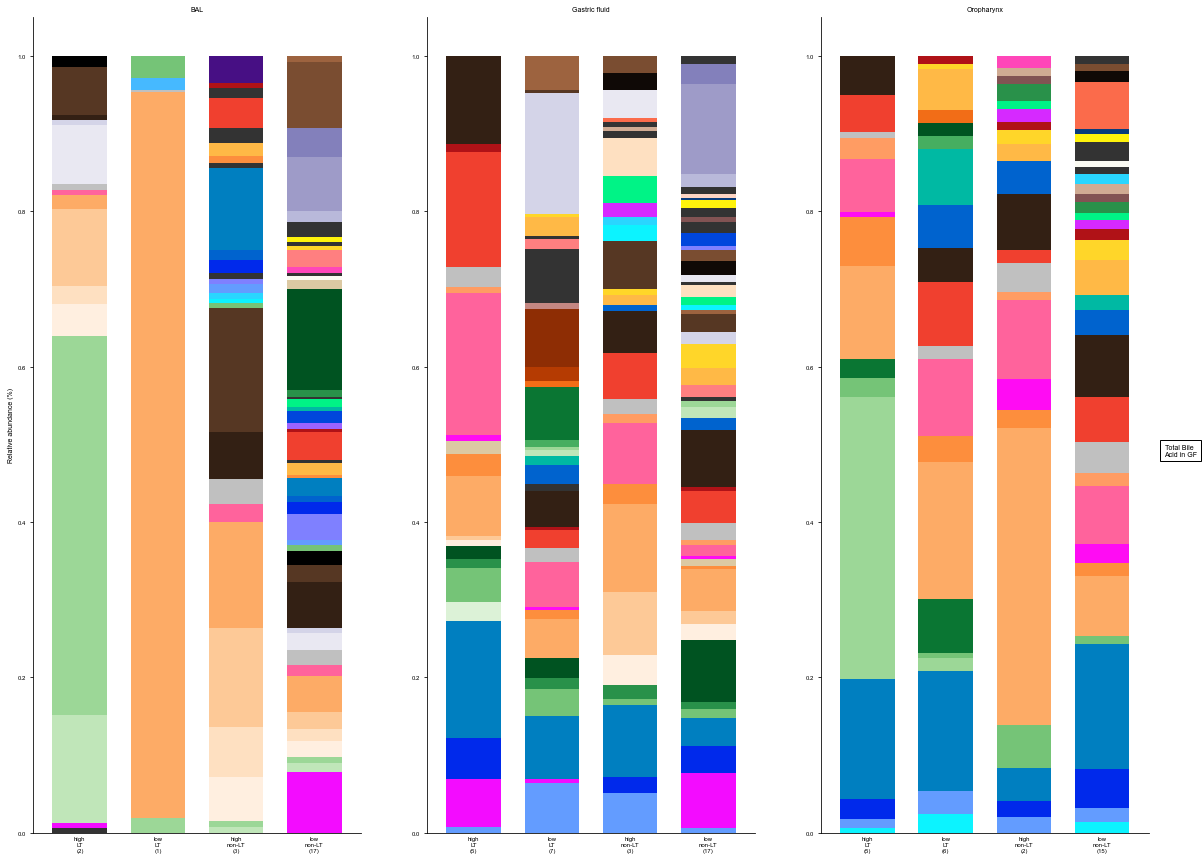

In [28]:
fig = plt.figure(figsize=(20,15))

ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1))
ax3 = plt.subplot2grid((1, 3), (0, 2))

width = 0.7


####### LUNG(0), STOMACH(1), THROAT(2) ###########

axes = [ax1, ax2, ax3]

taxa_list_reduced = []

for i, df in enumerate(BAplot_df):

    order_tmp = list(set(df['type'].tolist()))
    order = order_list(order_tmp)

    # To get the same color for the taxa each time when plotting 
    tax_list = []
    for x in range(len(list(df.set_index('type').loc[order].groupby(['type', 'Full Taxa'], sort=False).sum().unstack()))):
        tax_list.append(list(df.set_index('type').loc[order].groupby(['type', 'Full Taxa'], sort=False).sum().unstack())[x][1])

    hh = df.set_index('type').loc[order].groupby(['type', 'Full Taxa'], sort=False).sum().unstack().plot.bar(
        stacked=True, color=[test.get(x, '#333333') for x in tax_list], ax=axes[i], width = width, edgecolor = "k", linewidth=0)

    # To store which taxa are present in the plot
    for tax in tax_list:
        taxa_list_reduced.append(tax)

    axes[i].set_xlabel('')
    axes[i].legend().remove()
    axes[i].tick_params(axis='x', which= 'both', length=0)
    axes[i].tick_params(axis='y', labelsize=6)

    # Y axis label
    if i == 0:
        axes[i].set_ylabel('Relative abundance (%)', fontsize=7)

    # X ticks
    labels = [item.get_text() for item in axes[i].get_xticklabels()] 
    newlabels = []
    for lab in labels:
        if lab.split(' ')[-2] == 'Transplant':
            shorter = 'LT'
        elif lab.split(' ')[-2] == 'Other':
            shorter = 'non-LT'
        newname = lab.split(' ')[0] + '\n' + shorter + '\n' + lab.split(' ')[-1]
        newlabels.append(newname)

    axes[i].set_xticklabels(newlabels, fontsize=6, rotation=0)

    if i in [2]:
        axes[i].text(4, 0.5, 'Total Bile \nAcid in GF', fontsize=7, ha="center", va="top", 
                         color='black', bbox=dict(facecolor='none', edgecolor='black'))
        
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['bottom'].set_color('k')
    axes[i].spines['left'].set_color('k') 

        
# Adjusting x and y axis labels on subplot 1 and 2
ax1.set_title('BAL', fontsize = 7)
ax2.set_title('Gastric fluid', fontsize = 7)
ax3.set_title('Oropharynx', fontsize = 7)
